In [1]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
TF_ENABLE_ONEDNN_OPTS=0

In [3]:
# import zipfile

# filename = "/homes/imransharif/Mehwish/Dataset/DRIVE_Final_880.zip"

# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall()
#     print('Done')


In [4]:

import os
!pip install keras-preprocessing
!pip install scikit-image
import tensorflow as tf
import time
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

#from tqdm import tqdm_notebook, tnrange
from itertools import chain
# from skimage.io import imread, imshow, concatenate_images
# from skimage.transform import resize
# from skimage.morphology import label
from sklearn.model_selection import train_test_split
# import imageio

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Resizing
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D, AveragePooling2D
from keras.regularizers import l2
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras import backend as keras

from keras.utils import plot_model

from keras_preprocessing.image import array_to_img, img_to_array, load_img
import cv2
# import skimage.io as io

import glob
from PIL import Image
# import skimage
from keras.initializers import Constant

# from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
# from skimage.measure import label, regionprops
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_score

from keras import backend as K
from keras import layers, models
import zipfile
import random
import sys

# import skimage.io                           #Used for imshow function
# import skimage.transform                    #Used for resize function
# from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt
from keras.layers import Concatenate, add

import warnings
warnings.filterwarnings("ignore")
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
from keras.losses import binary_crossentropy
from sklearn.metrics import precision_recall_curve

/opt/software/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-2.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached scipy-1.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcvit-tensorflow 1.2.1 requires absl-py==1.2.0

In [5]:
# dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/DRIVE_Augmented/DRIVE_BioNet-Augmented'
# os.listdir(dataset_dir)

In [6]:
import tensorflow as tf
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice Coefficient for evaluating segmentation models.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    """
    Compute Dice Loss (1 - Dice Coefficient).
    """
    return 1 - dice_coef(y_true, y_pred)

def Jaccard_coef(y_true, y_pred, smooth=1e-6):
    """
    Compute Jaccard Index (Intersection over Union - IoU).
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def Jaccard_coef_loss(y_true, y_pred):
    """
    Compute Jaccard Loss (1 - IoU).
    """
    return 1 - Jaccard_coef(y_true, y_pred)

def threshold_binarize(x, threshold=0.5):
    """
    Apply thresholding to predictions to convert them into binary outputs.
    """
    return tf.cast(x >= threshold, tf.float32)

def iou(y_true, y_pred, threshold=0.5, smooth=1e-6):
    """
    Compute Intersection over Union (IoU) after thresholding y_pred.
    """
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(y_true, y_pred):
    """
    Compute Sensitivity (Recall).
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    """
    Compute Specificity.
    """
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def  DiceLoss(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice Loss for segmentation tasks.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Ensure shape match
    y_true_resized = tf.image.resize(y_true, (tf.shape(y_pred)[1], tf.shape(y_pred)[2]))
    
    intersection = tf.reduce_sum(y_pred * y_true_resized)
    denominator = tf.reduce_sum(y_pred**2) + tf.reduce_sum(y_true_resized**2)
    
    return 1 - (2. * intersection + smooth) / (denominator + smooth)

def bcc_Jaccard_coef_loss(y_true, y_pred):
    """
    Combined Dice Loss and IoU Loss for better segmentation performance.
    """
    iou_value = iou(y_true, y_pred, threshold=0.5)
    return DiceLoss(y_true, y_pred) + (1 - iou_value)


In [7]:
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'final_output1': DiceLoss},
#               metrics={'final_output1': [dice_coef, iou, sensitivity, specificity]})

# model.summary()

In [8]:
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=46,
#     layer_range=None
# )

In [9]:
import numpy as geek
def sem_attention_block(inputs):
    shape=inputs.shape
    F2=Conv2D(shape[3],1, padding='same') (inputs)
    F2=BatchNormalization() (F2)
    F2=Activation('relu') (F2)
    x1=MaxPooling2D(pool_size=(shape[1],shape[2]),padding='same')(F2)
    x2=AveragePooling2D(pool_size=(shape[1],shape[2]),padding='same')(F2)
    con1 = Concatenate()([x1,x2])
    F3=Conv2D(shape[3],1, padding='same') (con1)
    F3=BatchNormalization() (F3)
    F33=Activation('relu') (F3)
    xa=GlobalAveragePooling2D(keepdims=True)(inputs)
    xa=Conv2D(shape[3],1, padding='same') (xa)
    xaa=BatchNormalization() (xa)
    xaa=Activation('sigmoid') (xaa)
    xm=Multiply()([F33,xaa])
    xam=Add()([inputs,xm])
    return xam

In [10]:
# !pip install mamba-ssm


In [11]:
import tensorflow as tf
from tensorflow.keras import layers

# -----------------------------------------------
# FOCAL MODULATION BLOCK
# -----------------------------------------------
def focal_modulation(inputs, gamma=2.0, alpha=0.25):
    num_channels = inputs.shape[-1]

    mean = layers.GlobalAveragePooling2D()(inputs)
    max_val = layers.GlobalMaxPooling2D()(inputs)

    modulation = (max_val - mean) * alpha
    modulation = layers.Reshape((1, 1, num_channels))(modulation)
    modulation = layers.Conv2D(filters=num_channels, kernel_size=1, activation='sigmoid')(modulation)

    scaled_inputs = layers.Multiply()([inputs, modulation])
    outputs = layers.Lambda(lambda x: x ** gamma)(scaled_inputs)
    return outputs

# -----------------------------------------------
# FOCAL MODULATION + CONTEXT AGGREGATION BLOCK
# -----------------------------------------------
def focal_modulation_context_aggregation(inputs, filters):
    filters = int(filters)

    conv1 = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(inputs)

    conv2 = layers.Conv2D(filters, kernel_size=1, activation='relu')(inputs)
    global_context = layers.GlobalAveragePooling2D()(conv2)
    global_context = layers.Reshape((1, 1, filters))(global_context)
    global_context = layers.Conv2D(filters, kernel_size=1, activation='sigmoid')(global_context)
    global_context = layers.Multiply()([conv1, global_context])

    FM = focal_modulation(global_context)

    concatenated = layers.Concatenate()([conv1, FM])
    return concatenated

# -----------------------------------------------
# MAMBA-INSPIRED BLOCK
# -----------------------------------------------
class VisionMambaInspired(tf.keras.layers.Layer):
    def __init__(self, dim, dropout_rate=0.1):
        super().__init__()
        self.norm1 = layers.LayerNormalization()
        self.token_mixer = tf.keras.Sequential([
            layers.DepthwiseConv2D(kernel_size=3, padding='same'),
            layers.Activation('gelu'),
            layers.Dropout(dropout_rate),
        ])
        self.norm2 = layers.LayerNormalization()
        self.channel_mixer = tf.keras.Sequential([
            layers.Dense(dim * 4),
            layers.Activation('gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(dim),
            layers.Dropout(dropout_rate),
        ])

    def call(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.token_mixer(x) + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.channel_mixer(x) + shortcut
        return x

# -----------------------------------------------
# FINAL COMBINED BLOCK FOR BOTTLENECK
# -----------------------------------------------
def LiteFusion_Attention(input_tensor, filters, padding="same"):
    # Project input channels
    input_tensor = layers.Conv2D(filters, (1, 1), padding=padding)(input_tensor)

    # LayerNorm + Conv
    x = layers.LayerNormalization()(input_tensor)
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding=padding)(x)

    # Context aggregation with focal modulation
    x = focal_modulation_context_aggregation(x, filters)

    # Project back to match residual shape
    x = layers.Conv2D(filters, (1, 1), padding=padding)(x)

    # Residual connection
    out = layers.Add()([x, input_tensor])

    # Vision Mamba Block
    out = VisionMambaInspired(dim=filters)(out)

    return out
input_shape = (512,512,3)
# inputs = layers.Input(shape=input_shape)
# p = LiteFusion_Attention(inputs, filters=24)
# output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid',name = 'final_output1')(p)
# model = models.Model(inputs=inputs, outputs=[output])
# model = LiteFusion_Attention(inputs, filters=32)
# model.summary()

In [13]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate
from keras import backend as K


#  import numpy as np
def RA_attention_block(inputs,n_classes,k):
    shape=K.int_shape(inputs)
    # F=Conv2D(k*n_classes,1, padding='same') (inputs)
    F=Conv2D(k*n_classes,3, padding='same') (inputs)
    F=BatchNormalization() (F)
    F1=Activation('relu') (F)

    F2=F1

    x1=GlobalMaxPool2D()(F2)
    x2=GlobalAveragePooling2D()(F2)
    x = Multiply() ([x1,x2])
    x=Reshape((n_classes,k))(x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False)) (x)

    # x2=Reshape((n_classes,k)) (x)
    # S2=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x2)
    # S= S1+S2
    x=Reshape((shape[1],shape[2],n_classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    x=Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (x)

    semantic=Multiply()([inputs,M])
    return semantic

def conv_block(input, out_channels, dropout_rate=0.5):
    # Multi-scale convolutions
    conv1x1 = layers.Conv2D(out_channels, kernel_size=1, padding='same', use_bias=False)(input)
    conv3x3 = layers.Conv2D(out_channels, kernel_size=3, padding='same', use_bias=False)(input)
    conv3x3_dilated = layers.Conv2D(out_channels, kernel_size=3, padding='same', use_bias=False, dilation_rate=2)(input)
    
    # Fuse multi-scale outputs by summing them
    x = conv1x1 + conv3x3 + conv3x3_dilated
    x = layers.LeakyReLU(alpha=0.1)(x)
#     x = Dropout(dropout_rate)(x)
    return x


def LiteFusion_UNet(input_shape, num_classes, feature_scale=2, dropout=0.5):
    # Define the input layer
    filters = [int(x / feature_scale) for x in [16,32,64]]
    inputs = layers.Input(shape=input_shape)

    # Encoder - Convolutional Blocks
    conv_block1 = conv_block(inputs, filters[0], dropout)
#     conv_block1 = layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_block1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block1 = layers.BatchNormalization()(conv_block1)

    conv_block2 = conv_block(conv_block1, filters[1], dropout)
#     conv_block2 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv_block1)
    conv_block2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block2 = layers.BatchNormalization()(conv_block2)

    conv_block3 = conv_block(conv_block2, filters[2], dropout)
#     conv_block3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv_block2)
    conv_block3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_block3)
    conv_block3 = layers.BatchNormalization()(conv_block3)

    attention_output = LiteFusion_Attention(conv_block3, filters=32)


    # Concatenate the Encoder Convolutional and Transformer blocks

    att1 = RA_attention_block(attention_output,1,16)
    fused_features = layers.Concatenate()([att1, attention_output])

    # Decoder - Upsampling Blocks
    decoder_block1 = layers.Conv2DTranspose(filters[2], kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    att2 = RA_attention_block(conv_block2,1,16)
    decoder_block1 = layers.Concatenate()([att2, decoder_block1])
    decoder_block1 = layers.Conv2D(filters[2], kernel_size=(3, 3), padding='same', activation='relu')(decoder_block1)

    decoder_block2 = layers.Conv2DTranspose(filters[2], kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block1)

    att3=RA_attention_block(conv_block1,1,16)
    decoder_block2 = layers.Concatenate()([att3, decoder_block2])
    decoder_block2 = layers.Conv2D(filters[2], kernel_size=(3, 3), padding='same', activation='relu')(decoder_block2)


    decoder_block3 = layers.Conv2DTranspose(filters[0], kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(decoder_block2)
    decoder_block3 = layers.Conv2D(filters[0], kernel_size=(3, 3), padding='same', activation='relu')(decoder_block3)
    # Decoder - Output Block
    output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid',name = 'final_output1')(decoder_block3)
#     output_OD = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', name = 'final_output2')(decoder_block3)

    # Create the model
    model = models.Model(inputs=inputs, outputs=[output])

    return model

# Define the input shape for binary semantic segmentation
input_shape = (512,512,3)  # Example input shape for RGB images

# Create the TransFuse Encoder-Decoder model with 3 MaxPooling layers for binary semantic segmentation
model = LiteFusion_UNet(input_shape, 1, feature_scale=2, dropout=0.5)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  24          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 8)  216         ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 512, 512, 8)  0          ['conv2d[0][0]',             

In [15]:
train_data ='' #data path
valid_data = ''

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize

# Set the desired image dimensions
im_height = 512
im_width = 512

# Function to get and resize train images and masks for binary segmentation
def get_data(path):
    # Paths to images and masks directories
    images_paths = os.path.join(path, 'images')
    masks_path_BV = os.path.join(path, 'GT_BV')

    # Get the list of image and mask files, sorted for consistency
    images_ids = sorted(os.listdir(images_paths))
    mask1_ids = sorted(os.listdir(masks_path_BV))

    # Initialize arrays to hold the images and masks
    X = np.zeros((len(images_ids), im_height, im_width, 3), dtype=np.float32)  # For RGB images
    y1 = np.zeros((len(mask1_ids), im_height, im_width, 1), dtype=np.float32)  # For binary masks

    print('Getting and resizing images ... ')
    for n in range(len(images_ids)):
        try:
            # Load and resize the images
            img = img_to_array(load_img(os.path.join(images_paths, images_ids[n]), grayscale=False))  # Load as RGB
            x_img = resize(img, (im_height, im_width, 3), mode='constant', preserve_range=True)  # Resize image

            # Load and resize the masks
            mask_BV = img_to_array(load_img(os.path.join(masks_path_BV, mask1_ids[n]), grayscale=True))  # Load as grayscale
            mask_BV = resize(mask_BV, (im_height, im_width, 1), mode='constant', preserve_range=True)  # Resize mask

            # Normalize the image and mask values to the range [0, 1]
            X[n] = x_img / 255.0
            y1[n] = mask_BV / 255.0
        except Exception as e:
            # Handle non-image files or other loading issues
            print(f"Skipping file {images_ids[n]} or {mask1_ids[n]} due to an error: {e}")
            continue

    print('Done!')
    return X, y1

# Example usage:
# train_data = "path_to_your_data_folder"  # Replace with the path to your data directory
# X, y1 = get_data(train_data)
# print("X_train shape:", X.shape)
# print("y1_train shape:", y1.shape)


In [17]:
X, y1 = get_data(train_data)

print("X_train shape:", X.shape)
print("y1_train shape:", y1.shape)

Getting and resizing images ... 
Done!
X_train shape: (880, 512, 512, 3)
y1_train shape: (880, 512, 512, 1)


In [18]:
# prompt: ADD TRAIN TEST SPLIT AND PRINT SHAPES

# Get and resize train images and masks

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.20, random_state=42)


# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y1_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y1_test shape:", y_test.shape)


X_train shape: (704, 512, 512, 3)
y1_train shape: (704, 512, 512, 1)
X_test shape: (176, 512, 512, 3)
y1_test shape: (176, 512, 512, 1)


In [19]:
# prompt: convert masks into logical values and print shapes

y_train = np.array(y_train > 0.5, dtype=np.uint8)
y_test = np.array(y_test > 0.5, dtype=np.uint8)
# y2_train_od = np.array(y2_train_od > 0.5, dtype=np.uint8)
# y2_test_od = np.array(y2_test_od > 0.5, dtype=np.uint8)




In [20]:
# # prompt: display masks and print unique values

# ix = random.randint(0, len(X_train))
# imshow(X_train[ix])
# plt.show()
# imshow(np.squeeze(y_train[ix]))
# plt.show()


# print(np.unique(y_train[ix]))
# print(np.unique(y_test[ix]))


In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
nb_epoch = 300
batch_size=16
earlystopper = EarlyStopping(patience=10, verbose=1)
# Append '.weights.h5' to the filename
checkpoint = ModelCheckpoint('LiteFusion-Net_DRIVE.h5',
                             verbose=1, save_best_only=True,save_weights_only=True)
callbacks = [checkpoint]

In [23]:
# Import necessary libraries
from keras.optimizers import Adam
import tensorflow as tf
# model.compile(optimizer=Adam(0.002), loss=DiceLoss, metrics=['accuracy',dice_coef, Jaccard_coef,sensitivity, specificity])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=DiceLoss,  # Ensure this is a valid loss function and not None
    metrics=['accuracy', dice_coef, Jaccard_coef]  # Ensure metrics are properly defined
)


In [24]:
results = model.fit(
    X_train,
    y_train,  # Pass y_train directly without brackets
    batch_size=batch_size,
    epochs=nb_epoch,
    callbacks=callbacks,
    validation_data=(X_test, y_test)  # Pass y_test directly without brackets
)


Epoch 1/300


2025-05-01 20:05:56.349663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/vision_mamba_inspired/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9668 - dice_coef: 0.7354 - Jaccard_coef: 0.5817
Epoch 1: val_loss improved from inf to 0.15674, saving model to /homes/imransharif/Mehwish/Year 3/Mamba_Block/AV_weights/RetinaNet-Hybrid_Attention_New-Combined_DRIVE-Final.h5
44/44 [==============================] - 26s 265ms/step - loss: 0.1585 - accuracy: 0.9668 - dice_coef: 0.7354 - Jaccard_coef: 0.5817 - val_loss: 0.1567 - val_accuracy: 0.9673 - val_dice_coef: 0.7322 - val_Jaccard_coef: 0.5777
Epoch 2/300
44/44 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9679 - dice_coef: 0.7435 - Jaccard_coef: 0.5919
Epoch 2: val_loss improved from 0.15674 to 0.15666, saving model to /homes/imransharif/Mehwish/Year 3/Mamba_Block/AV_weights/RetinaNet-Hybrid_Attention_New-Combined_DRIVE-Final.h5
44/44 [==============================] - 10s 230ms/step - loss: 0.1528 - accuracy: 0.9679 - dice_coef: 0.7435 - Jaccard_coef: 0.5919 - val_loss: 0.1567 - 

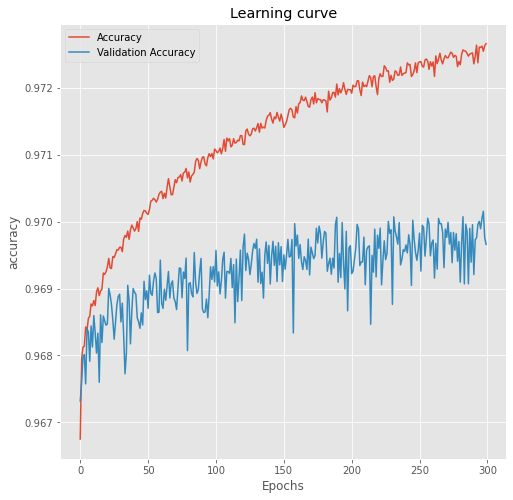

In [26]:
# Modifying the code for a single output
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
# Assuming results.history['loss'] and results.history['val_loss'] correspond to the single output loss
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


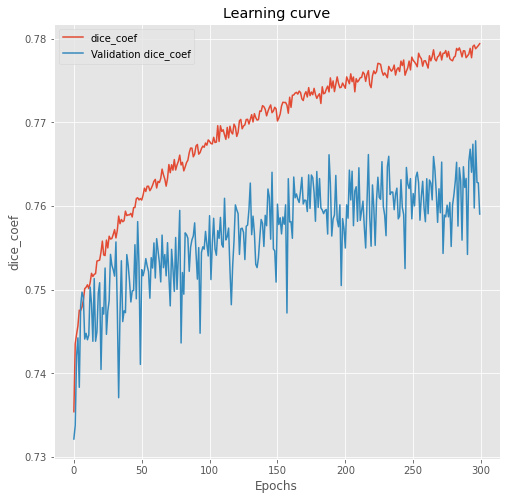

In [27]:
# Modifying the code for a single output
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
# Assuming results.history['loss'] and results.history['val_loss'] correspond to the single output loss
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="Validation dice_coef")

plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend()
plt.show()

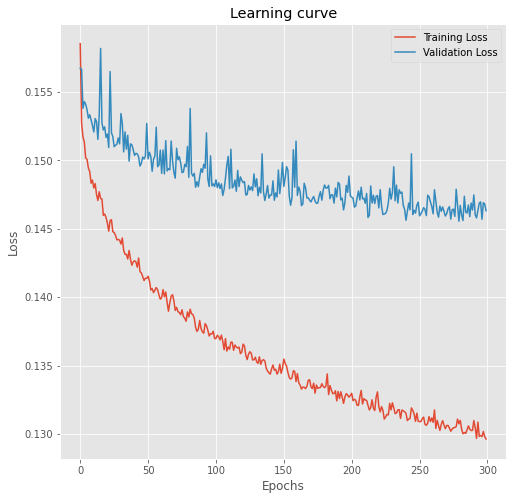

In [28]:
# Modifying the code for a single output
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
# Assuming results.history['loss'] and results.history['val_loss'] correspond to the single output loss
plt.plot(results.history["loss"], label="Training Loss")
plt.plot(results.history["val_loss"], label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [29]:
def evaluate_metrics(y_test, y_pred):
    n = y_pred.shape[0]
    all_F1_score = np.zeros(n)
    all_dice = np.zeros(n)
    all_jaccard = np.zeros(n)
    all_sensitivity = np.zeros(n)
    all_specificity = np.zeros(n)
    for i in range(n):
        gt, pred = y_test[i], y_pred[i]
        gt_flt = np.ndarray.flatten(gt)
        pred_flt = np.ndarray.flatten(pred)

        precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
        f1 = 2*(precisions * recalls) / (precisions + recalls)
        max_value = np.argmax(f1)
        thres = thresholds[max_value]
        pred_mask = (pred_flt >= thres)
        pred_label = pred_mask*1

        tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()

        F1_score = tp/(tp+((0.5)*(fp+fn)))
        iou = tp / (tp + fp + fn)
        dice = 2*tp / (2*tp + fp + fn)
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)

        all_F1_score[i] = F1_score
        all_dice[i] = dice
        all_jaccard[i] = iou
        all_sensitivity[i] = recall
        all_specificity[i] = specificity

        print(' F1_score: {:4f}, Dice: {:4f}, Jaccard: {:4f}, Sensitivity: {:4f}, Specificity: {:4f}'.format(
        np.nanmean(all_F1_score), np.nanmean(all_dice), np.nanmean(all_jaccard), np.nanmean(all_sensitivity), np.nanmean(all_specificity)
        ))
    return all_F1_score, all_dice, all_jaccard, all_sensitivity, all_specificity


In [30]:
# model.save_weights('/homes/imransharif/Mehwish/DRIVE/AV_weights/FR_UNet_RAAM_DRIVE.h5')

In [31]:
# valid_data = '/content/ISIC2018_256x256/test' #data path
X_test, y_test = get_data(valid_data)

Getting and resizing images ... 
Done!


In [32]:
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

def evaluate_metrics(y_test, y_pred, return_mode='all'):
    n = y_pred.shape[0]
    all_accuracy = np.zeros(n)
    all_dice = np.zeros(n)
    all_jaccard = np.zeros(n)
    all_sensitivity = np.zeros(n)
    all_specificity = np.zeros(n)
    for i in range(n):
        gt, pred = y_test[i], y_pred[i]
        gt_flt = np.ndarray.flatten(gt)
        pred_flt = np.ndarray.flatten(pred)

        precisions, recalls, thresholds = precision_recall_curve(gt_flt, pred_flt)
        f1 = 2*(precisions * recalls) / (precisions + recalls)
        max_value = np.argmax(f1)
        precision, recall, thres = precisions[max_value], recalls[max_value], thresholds[max_value]

        maxval = 255
        pred_mask = (pred_flt > thres)
        pred_label = pred_mask*1

        tn, fp, fn, tp = confusion_matrix(gt_flt, pred_label).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        iou = tp / (tp + fp + fn)
        dice = 2*tp / (2*tp + fp + fn)
        specificity = tn / (tn + fp)

        all_accuracy[i] = accuracy
        all_dice[i] = dice
        all_jaccard[i] = iou
        all_sensitivity[i] = recall
        all_specificity[i] = specificity

    print('Accuracy: {:4f}, Dice: {:4f}, Jaccard: {:4f}, Sensitivity: {:4f}, Specificity: {:4f}'.format(
        np.nanmean(all_accuracy), np.nanmean(all_dice), np.nanmean(all_jaccard), np.nanmean(all_sensitivity), np.nanmean(all_specificity)
    ))
    if return_mode == 'all':
        return all_accuracy, all_dice, all_jaccard, all_sensitivity, all_specificity
    if return_mode == 'value':
        return np.nanmean(all_accuracy), np.nanmean(all_dice), np.nanmean(all_jaccard), np.nanmean(all_sensitivity), np.nanmean(all_specificity)
    else:
        return 'No val returned'

In [33]:
# Convert ground truth labels to binary
y_test_BV = (y_test[0] > 0.5).astype(np.uint8)
# y_test_OD = (y_test[1] > 0.5).astype(np.uint8)

y_pred = model.predict(X_test, batch_size =1 ,verbose=1)

# y_pred = model.predict(X_test)
# evl = evaluate_metrics(y_test_BV, y_pred, return_mode='all')

20/20 [==============================] - 2s 7ms/step


In [35]:
# Convert model's outputs to binary
predictions_BV = (y_pred[0] > 0.5).astype(np.uint8)
# predictions_OD = (predictions[1] > 0.5).astype(np.uint8)



In [37]:
memory_usage = model.count_params() * 4  # Assuming float32 data type (4 bytes per parameter)
print("Memory Usage: {:.2f} MB".format(memory_usage / 1024 / 1024))  # Divide by 1024 twice to convert from bytes to KB, then KB to MB


Memory Usage: 0.42 MB


In [38]:
#   !pip install keras-flops
  from keras_flops import get_flops

  flops = get_flops(model)
  print(f"FLOPs: {flops / 10**9:.03} G")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed